<a href="https://colab.research.google.com/github/itrinia/code-TA/blob/main/ta_ileene_v3_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

def ensure_folders_exist(folder_paths):
  """Ensures that the specified folders exist.

  Args:
    folder_paths: A list of folder paths to create.
  """
  for path in folder_paths:
    if not os.path.exists(path):
      os.makedirs(path)
      print(f"Created folder: {path}")
    else:
      print(f"Folder already exists: {path}")

# Define the folder paths as variables.
augmented_images_path = "/content/drive/MyDrive/TA Ileene/augmented/images"
augmented_labels_path = "/content/drive/MyDrive/TA Ileene/augmented/labels"
val_images_path = "/content/drive/MyDrive/TA Ileene/val/images"
val_labels_path = "/content/drive/MyDrive/TA Ileene/val/labels"


# Create a list of the folder paths.
folder_paths = [
    augmented_images_path,
    augmented_labels_path,
    val_images_path,
    val_labels_path
]

# Call the function to ensure the folders exist.
ensure_folders_exist(folder_paths)


Folder already exists: /content/drive/MyDrive/TA Ileene/augmented/images
Folder already exists: /content/drive/MyDrive/TA Ileene/augmented/labels
Folder already exists: /content/drive/MyDrive/TA Ileene/val/images
Folder already exists: /content/drive/MyDrive/TA Ileene/val/labels


In [4]:
# Cell 2: Sanity‐check file counts
print("→ Train images:", len(os.listdir(augmented_images_path)))
print("→ Train labels:", len(os.listdir(augmented_labels_path)))
print("→ Val   images:", len(os.listdir(val_images_path)))
print("→ Val   labels:", len(os.listdir(val_labels_path)))

→ Train images: 10550
→ Train labels: 10550
→ Val   images: 2262
→ Val   labels: 2262


In [5]:
labels_path = '/content/drive/MyDrive/TA Ileene/augmented/labels'

# List the files in the labels directory
labels_files = os.listdir(labels_path)
print("Files in the labels directory:", labels_files)

Files in the labels directory: ['108-acf47c1b.npz', '106-031b0134.npz', '105-e7dea00e.npz', '109-b4bb802d.npz', '109-9585d9a0.npz', '111-8eea76b6.npz', '108-6fc6df11.npz', '107-d40a9d96.npz', '105-36cd8970.npz', '102-5dbec013.npz', '107-3d09939d.npz', '108-be56ce50.npz', '104-99ae99c6.npz', '104-9eaa1733.npz', '104-a798f4ff.npz', '105-26333c1d.npz', '103-f64b7079.npz', '104-99964f03.npz', '106-4b31b39d.npz', '105-3c0d2304.npz', '106-61495ec9.npz', '108-999bdeeb.npz', '104-96b62fe9.npz', '105-56c64c5e.npz', '105-e5ea3a86.npz', '105-82c541d2.npz', '108-1c390bc5.npz', '105-1c8dbfff.npz', '11-cc147df4.npz', '109-216d1929.npz', '108-d4357960.npz', '107-a7663923.npz', '105-c0bff5f3.npz', '109-5d77e842.npz', '107-f4353cc0.npz', '11-833ac14c.npz', '110-0e96f4f6.npz', '103-468c21ea.npz', '108-61d6ed3d.npz', '109-eef0790c.npz', '11-03dedf31.npz', '110-ba2d0d93.npz', '108-c2039640.npz', '11-758e649f.npz', '109-ef4167d4.npz', '11-78d9fdb8.npz', '11-56e6950b.npz', '104-20f7b08a.npz', '104-1d07b2e8.

In [17]:

!pip install -q tensorflow opencv-python matplotlib scikit-learn scikit-image

# define model

In [18]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Activation, Add, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import datetime
import glob
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import tensorflow.keras.backend as K
import time

In [19]:
# Create a directory to save models
MODEL_SAVE_PATH = "/content/drive/MyDrive/TA Ileene/models"
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

# Parameters
IMG_SIZE = 512
BATCH_SIZE = 16
EPOCHS = 20
LEARNING_RATE = 1e-4
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 1)

In [20]:
# Define the residual block
def residual_block(x, filters):
    # First convolution layer
    conv1 = Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    conv1 = Activation('relu')(conv1)

    # Second convolution layer
    conv2 = Conv2D(filters, kernel_size=(3, 3), padding='same')(conv1)
    conv2 = Activation('relu')(conv2)

    # Skip connection
    skip = Add()([x, conv2])
    return skip

# Define the attention mechanism
def attention_block(x, g, filters):
    # Query and Key
    theta_x = Conv2D(filters, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)
    phi_g = Conv2D(filters, kernel_size=(1, 1), strides=(1, 1), padding='same')(g)

    # Add and apply ReLU
    add_xg = Add()([theta_x, phi_g])
    add_xg = Activation('relu')(add_xg)

    # Attention map
    psi = Conv2D(1, kernel_size=(1, 1), strides=(1, 1), padding='same')(add_xg)
    psi = Activation('sigmoid')(psi)

    # Apply attention
    return Multiply()([x, psi])


# Define the DocUNet model
def build_docunet(input_shape=(512, 512, 1)):
    inputs = Input(input_shape)

    # Encoder
    x = Conv2D(64, kernel_size=(3, 3), padding='same')(inputs)
    x = Activation('relu')(x)
    res1 = residual_block(x, 64)
    x = MaxPooling2D(pool_size=(2, 2))(res1)

    x = Conv2D(128, kernel_size=(3, 3), padding='same')(x)
    x = Activation('relu')(x)
    res2 = residual_block(x, 128)
    x = MaxPooling2D(pool_size=(2, 2))(res2)

    x = Conv2D(256, kernel_size=(3, 3), padding='same')(x)
    x = Activation('relu')(x)
    res3 = residual_block(x, 256)
    x = MaxPooling2D(pool_size=(2, 2))(res3)

    x = Conv2D(512, kernel_size=(3, 3), padding='same')(x)
    x = Activation('relu')(x)
    res4 = residual_block(x, 512)
    x = MaxPooling2D(pool_size=(2, 2))(res4)

    # Bottleneck with attention
    g = Conv2D(512, kernel_size=(3, 3), padding='same')(x)
    g = Activation('relu')(g)
    g = attention_block(g, x, 512)

    # Decoder
    x = Conv2DTranspose(512, kernel_size=(3, 3), strides=(2, 2), padding='same')(g)
    x = concatenate([x, res4])
    x = Activation('relu')(x)

    x = Conv2DTranspose(256, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = concatenate([x, res3])
    x = Activation('relu')(x)

    x = Conv2DTranspose(128, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = concatenate([x, res2])
    x = Activation('relu')(x)

    x = Conv2DTranspose(64, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = concatenate([x, res1])
    x = Activation('relu')(x)


    # Output layer
    outputs = Conv2D(1, kernel_size=(1, 1), activation='sigmoid')(x)

    # Build the model
    model = Model(inputs, outputs)
    return model

# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 512, 512,  │          0 │ conv2d[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 512, 512,  │          0 │ conv2d_1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 512, 512,  │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 512, 512,  │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 512, 512,  │          0 │ activation[0][0], │
│                     │ 64)               │            │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ add[0][0]         │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256, 256,  │          0 │ conv2d_3[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 256, 256,  │    147,584 │ activation_3[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 256, 256,  │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 256, 256,  │    147,584 │ activation_4[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 256, 256,  │          0 │ conv2d_5[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256, 256,  │          0 │ activation_3[0][… │
│                     │ 128)              │            │ activation_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ add_1[0][0]     

 Total params: 16,161,218 (61.65 MB)

 Trainable params: 16,161,218 (61.65 MB)

 Non-trainable params: 0 (0.00 B)

# custom metrics for eval

In [21]:
# Define SSIM and PSNR metrics for TensorFlow
def tf_ssim(y_true, y_pred):
    """TensorFlow implementation of structural similarity index"""
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

def tf_psnr(y_true, y_pred):
    """TensorFlow implementation of peak signal-to-noise ratio"""
    return tf.reduce_mean(tf.image.psnr(y_true, y_pred, 1.0))

# Data Generation

In [31]:
class DocuNetDataGenerator(tf.keras.utils.Sequence):
    """Custom data generator for DocUNet with NPZ labels"""
    def __init__(self, image_paths, label_paths, batch_size, img_size, is_training=True):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.batch_size = batch_size
        self.img_size = img_size
        self.is_training = is_training
        self.indexes = np.arange(len(self.image_paths))
        if self.is_training:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, idx):
        # Get batch indexes
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Get batch file paths
        batch_image_paths = [self.image_paths[i] for i in batch_indexes]
        batch_label_paths = [self.label_paths[i] for i in batch_indexes]

        # Initialize batch arrays
        batch_size = len(batch_image_paths)
        batch_x = np.zeros((batch_size, self.img_size, self.img_size, 1), dtype=np.float32)
        batch_y = np.zeros((batch_size, self.img_size, self.img_size, 1), dtype=np.float32)

        # Load and preprocess images and labels
        for i, (img_path, label_path) in enumerate(zip(batch_image_paths, batch_label_paths)):
            # Load and preprocess image (PNG)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Warning: Failed to load {img_path}")
                continue

            # Resize image
            img = cv2.resize(img, (self.img_size, self.img_size))

            # Normalize to [0, 1]
            img = img.astype(np.float32) / 255.0

            # Load and preprocess label (NPZ file)
            try:
                # Try to load the file in different ways
                try:
                    # First attempt: standard npz file
                    with np.load(label_path, allow_pickle=True) as data:
                        if hasattr(data, 'files'):
                            for key in data.files:
                                label = data[key]
                                break
                        else:
                            # It's a direct array
                            label = data
                except:
                    # Second attempt: direct array file
                    label = np.load(label_path, allow_pickle=True)

                # Ensure it's a numpy array
                if not isinstance(label, np.ndarray):
                    label = np.array(label)

                # Resize the label
                if label.ndim == 3 and label.shape[2] == 1:
                    # Already has channel dimension
                    label = cv2.resize(label[:,:,0], (self.img_size, self.img_size))
                elif label.ndim == 3 and label.shape[2] > 1:
                    # Convert to grayscale if it's RGB
                    label = cv2.cvtColor(label, cv2.COLOR_RGB2GRAY)
                    label = cv2.resize(label, (self.img_size, self.img_size))
                else:
                    # Already grayscale
                    label = cv2.resize(label, (self.img_size, self.img_size))

                # Normalize to [0, 1] if not already
                if label.max() > 1.0:
                    label = label.astype(np.float32) / 255.0

            except Exception as e:
                print(f"Error loading label {label_path}: {e}")
                # Create an empty label as fallback
                label = np.zeros((self.img_size, self.img_size), dtype=np.float32)

            # Add batch dimension
            batch_x[i,:,:,0] = img
            batch_y[i,:,:,0] = label

        return batch_x, batch_y

    def on_epoch_end(self):
        """Shuffle indexes after each epoch"""
        if self.is_training:
            np.random.shuffle(self.indexes)

# Data Loading and Preparation

In [32]:
def load_file_paths(images_dir, labels_dir):
    """Load and match image and label file paths"""
    # Find all image and label files
    image_paths = sorted(glob.glob(os.path.join(images_dir, '*.png')))
    label_paths = sorted(glob.glob(os.path.join(labels_dir, '*.npz')))

    print(f"Found {len(image_paths)} image files and {len(label_paths)} label files")

    # Match image and label files by base name
    paired_images = []
    paired_labels = []

    # Create a dictionary of label paths for faster lookup
    label_dict = {os.path.splitext(os.path.basename(path))[0]: path for path in label_paths}

    for img_path in image_paths:
        # Get base name without extension
        img_name = os.path.splitext(os.path.basename(img_path))[0]

        # Look for matching label file
        if img_name in label_dict:
            paired_images.append(img_path)
            paired_labels.append(label_dict[img_name])

    print(f"Found {len(paired_images)} paired image-label files")
    return paired_images, paired_labels

# Load training data
print(f"Loading training data from {augmented_images_path} and {augmented_labels_path}")
train_img_paths, train_label_paths = load_file_paths(augmented_images_path, augmented_labels_path)

# Load validation data
print(f"Loading validation data from {val_images_path} and {val_labels_path}")
val_img_paths, val_label_paths = load_file_paths(val_images_path, val_labels_path)

# Check if we have data
if len(train_img_paths) == 0:
    raise ValueError("No paired training image-label files found. Check your data paths.")
if len(val_img_paths) == 0:
    raise ValueError("No paired validation image-label files found. Check your data paths.")

print(f"Training samples: {len(train_img_paths)}")
print(f"Validation samples: {len(val_img_paths)}")

# Create data generators
train_generator = DocuNetDataGenerator(train_img_paths, train_label_paths, BATCH_SIZE, IMG_SIZE, is_training=True)
val_generator = DocuNetDataGenerator(val_img_paths, val_label_paths, BATCH_SIZE, IMG_SIZE, is_training=False)

Loading training data from /content/drive/MyDrive/TA Ileene/augmented/images and /content/drive/MyDrive/TA Ileene/augmented/labels
Found 10550 image files and 10550 label files
Found 10550 paired image-label files
Loading validation data from /content/drive/MyDrive/TA Ileene/val/images and /content/drive/MyDrive/TA Ileene/val/labels
Found 2262 image files and 2262 label files
Found 2262 paired image-label files
Training samples: 10550
Validation samples: 2262


# Visualize Sample Data:

Visualizing sample training data:
Error loading label /content/drive/MyDrive/TA Ileene/augmented/labels/103-64fa884b.npz: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - src data type = object is not supported
>  - Expected Ptr<cv::UMat> for argument 'src'

Error loading label /content/drive/MyDrive/TA Ileene/augmented/labels/105-5ea9fe10.npz: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - src data type = object is not supported
>  - Expected Ptr<cv::UMat> for argument 'src'

Error loading label /content/drive/MyDrive/TA Ileene/augmented/labels/107-8984b7d0.npz: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - src data type = object is not supported
>  - Expected Ptr<cv::UMat> for argument 'src'

Error loading label /content/drive/MyDrive/TA Ileene/augmented/labels/112-88e34fb2.npz: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in

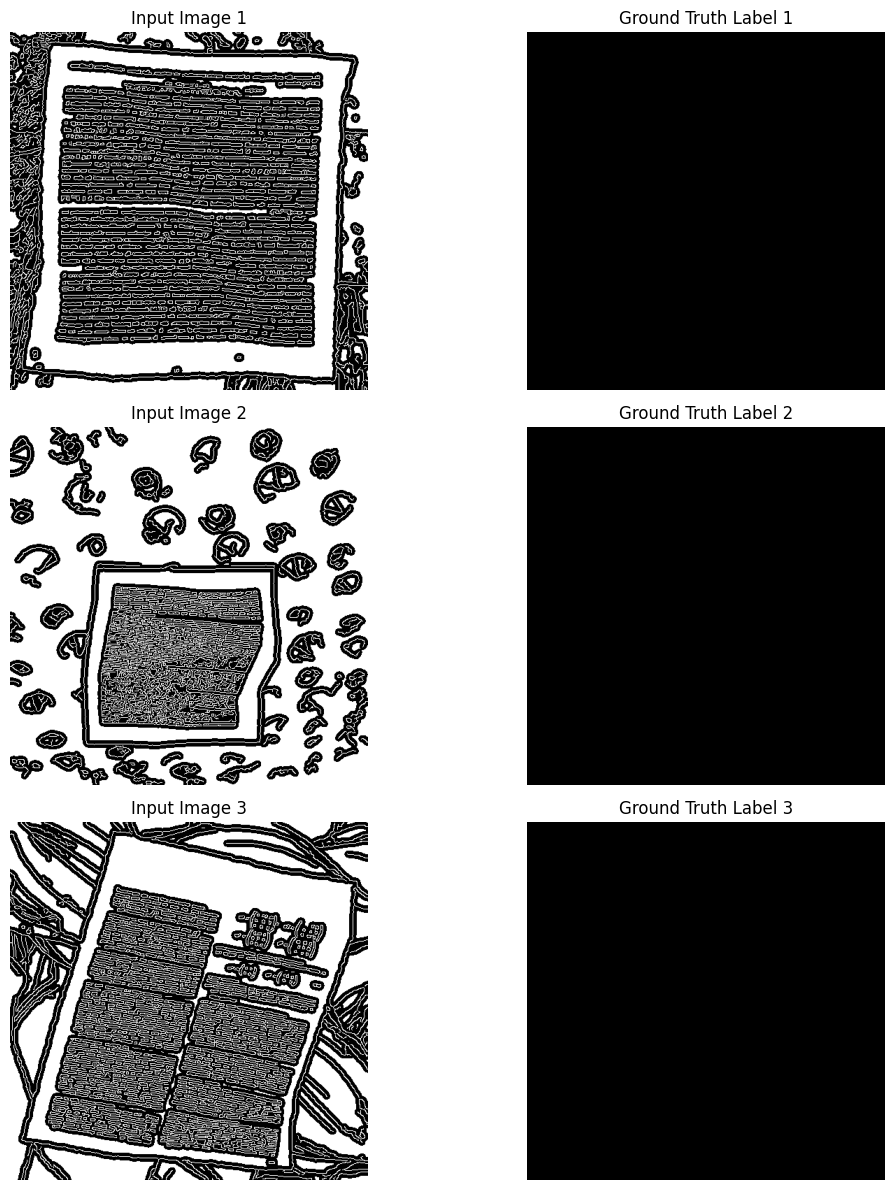

In [33]:
# Visualize some examples from the training generator
def visualize_samples(generator, num_samples=3):
    # Get batch
    x_batch, y_batch = generator[0]

    plt.figure(figsize=(12, 4*num_samples))
    for i in range(min(num_samples, len(x_batch))):
        # Display input image
        plt.subplot(num_samples, 2, i*2+1)
        plt.imshow(x_batch[i, :, :, 0], cmap='gray')
        plt.title(f"Input Image {i+1}")
        plt.axis('off')

        # Display label
        plt.subplot(num_samples, 2, i*2+2)
        plt.imshow(y_batch[i, :, :, 0], cmap='gray')
        plt.title(f"Ground Truth Label {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize samples to verify data loading
print("Visualizing sample training data:")
visualize_samples(train_generator, num_samples=3)

In [34]:
# Debugging cell to check label format
sample_label_path = train_label_paths[0]  # Get the first label path
print(f"Examining label file: {sample_label_path}")
try:
    label_data = np.load(sample_label_path, allow_pickle=True)
    print(f"Type: {type(label_data)}")
    print(f"Has 'files' attribute: {hasattr(label_data, 'files')}")
    print(f"Shape: {label_data.shape if hasattr(label_data, 'shape') else 'No shape'}")
    if hasattr(label_data, 'files'):
        print(f"Keys: {label_data.files}")
except Exception as e:
    print(f"Error: {e}")

Examining label file: /content/drive/MyDrive/TA Ileene/augmented/labels/1-d2a1c88c.npz
Type: <class 'numpy.ndarray'>
Has 'files' attribute: False
Shape: ()


# Build and Compile Model:

In [ ]:
# Build the model
model = build_docunet(INPUT_SHAPE)

# Compile the model with binary crossentropy loss and SSIM/PSNR metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy', tf_ssim, tf_psnr]
)

# Print model summary
model.summary()

# Set Up Callbacks

In [ ]:
# Set up callbacks
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = os.path.join(MODEL_SAVE_PATH, f"logs_{timestamp}")
os.makedirs(log_dir, exist_ok=True)

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,  # Stop if no improvement for 10 epochs
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=os.path.join(MODEL_SAVE_PATH, 'docunet_best.h5'),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    TensorBoard(
        log_dir=log_dir,
        histogram_freq=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

# Train the Model:

In [ ]:
# Train the model
print(f"Starting training with {len(train_img_paths)} training samples and {len(val_img_paths)} validation samples")
print(f"Batch size: {BATCH_SIZE}, Epochs: {EPOCHS}, Learning rate: {LEARNING_RATE}")

start_time = time.time()

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time
print(f"Training completed in {training_time/60:.2f} minutes")

# Save the Final Model:

In [ ]:
# Save the final model
final_model_path = os.path.join(MODEL_SAVE_PATH, 'docunet.h5')
model.save(final_model_path)
print(f"Final model saved to {final_model_path}")

# Visualize Training History

In [ ]:
# Plot training history
def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot loss
    axes[0, 0].plot(history.history['loss'])
    axes[0, 0].plot(history.history['val_loss'])
    axes[0, 0].set_title('Model Loss')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].legend(['Train', 'Validation'], loc='upper right')
    axes[0, 0].grid(True)

    # Plot accuracy
    axes[0, 1].plot(history.history['accuracy'])
    axes[0, 1].plot(history.history['val_accuracy'])
    axes[0, 1].set_title('Model Accuracy')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].legend(['Train', 'Validation'], loc='lower right')
    axes[0, 1].grid(True)

    # Plot SSIM
    axes[1, 0].plot(history.history['tf_ssim'])
    axes[1, 0].plot(history.history['val_tf_ssim'])
    axes[1, 0].set_title('Structural Similarity (SSIM)')
    axes[1, 0].set_ylabel('SSIM')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].legend(['Train', 'Validation'], loc='lower right')
    axes[1, 0].grid(True)

    # Plot PSNR
    axes[1, 1].plot(history.history['tf_psnr'])
    axes[1, 1].plot(history.history['val_tf_psnr'])
    axes[1, 1].set_title('Peak Signal-to-Noise Ratio (PSNR)')
    axes[1, 1].set_ylabel('PSNR (dB)')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].legend(['Train', 'Validation'], loc='lower right')
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(MODEL_SAVE_PATH, 'training_history.png'))
    plt.show()

# Plot training history
plot_training_history(history)

# Save history as CSV for later analysis
import pandas as pd
history_df = pd.DataFrame(history.history)
history_csv_path = os.path.join(MODEL_SAVE_PATH, 'training_history.csv')
history_df.to_csv(history_csv_path, index=False)
print(f"Training history saved to {history_csv_path}")

# Visualize Model Predictions:

In [ ]:
# Visualize model predictions on validation data
def visualize_predictions(model, generator, num_samples=3):
    # Get a batch of validation data
    x_batch, y_batch = generator[0]

    # Make predictions
    predictions = model.predict(x_batch[:num_samples])

    # Display images, ground truth, and predictions
    plt.figure(figsize=(15, 5*num_samples))
    for i in range(num_samples):
        # Display input image
        plt.subplot(num_samples, 3, i*3+1)
        plt.imshow(x_batch[i, :, :, 0], cmap='gray')
        plt.title('Distorted Input')
        plt.axis('off')

        # Display ground truth
        plt.subplot(num_samples, 3, i*3+2)
        plt.imshow(y_batch[i, :, :, 0], cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')

        # Display prediction
        plt.subplot(num_samples, 3, i*3+3)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.title('Model Prediction')
        plt.axis('off')

        # Calculate SSIM and PSNR for this sample
        sample_ssim = ssim(y_batch[i, :, :, 0], predictions[i, :, :, 0], data_range=1.0)
        sample_psnr = psnr(y_batch[i, :, :, 0], predictions[i, :, :, 0], data_range=1.0)

        print(f"Sample {i+1} - SSIM: {sample_ssim:.4f}, PSNR: {sample_psnr:.2f}dB")

    plt.tight_layout()
    plt.savefig(os.path.join(MODEL_SAVE_PATH, 'prediction_samples.png'))
    plt.show()

# Visualize predictions
print("Visualizing model predictions:")
visualize_predictions(model, val_generator, num_samples=3)

# Evaluate Model and Finish:

In [ ]:
# Evaluate model on validation set
print("Evaluating model on validation set...")
val_results = model.evaluate(val_generator, verbose=1)
print(f"Validation Loss: {val_results[0]:.4f}")
print(f"Validation Accuracy: {val_results[1]:.4f}")
print(f"Validation SSIM: {val_results[2]:.4f}")
print(f"Validation PSNR: {val_results[3]:.2f}dB")

# Save evaluation results
eval_results = {
    'val_loss': float(val_results[0]),
    'val_accuracy': float(val_results[1]),
    'val_ssim': float(val_results[2]),
    'val_psnr': float(val_results[3])
}

import json
with open(os.path.join(MODEL_SAVE_PATH, 'evaluation_results.json'), 'w') as f:
    json.dump(eval_results, f)

print("\n=== DocUNet Training Complete ===")
print(f"Model saved to: {final_model_path}")
print(f"Best model saved to: {os.path.join(MODEL_SAVE_PATH, 'docunet_best.h5')}")
print(f"Training history saved to: {history_csv_path}")
print(f"Evaluation results saved to: {os.path.join(MODEL_SAVE_PATH, 'evaluation_results.json')}")
print("\nNext steps:")
print("1. Download the model (.h5 file) to use locally")
print("2. Use the model for inference on new distorted document images")
print("3. Fine-tune the model if needed with additional data")